In [186]:
import seaborn as sns
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft, fftfreq, rfftfreq
from pydub import AudioSegment
import array

In [7]:
plt.rcParams["figure.figsize"] = (20,5)

In [177]:
amplitude = 1
frequency = 6

In [193]:
point_count = 400
cycles = 4

In [194]:
func = lambda x: amplitude * np.sin(2 * pi * x * frequency)
X = np.linspace(0, cycles, point_count, endpoint=False)
Y = func(X)

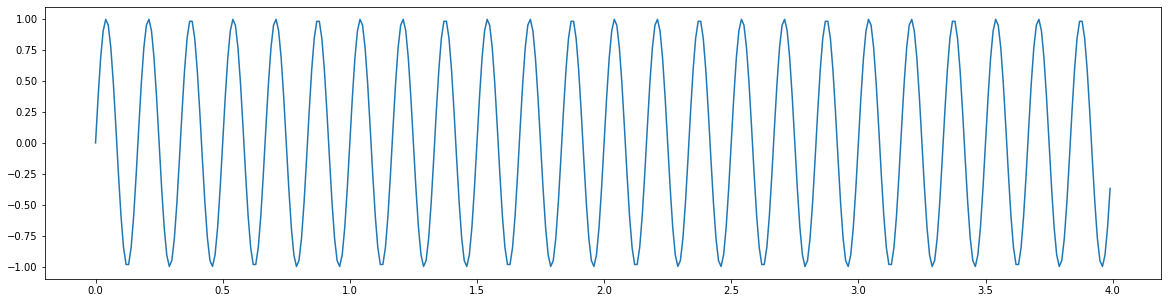

In [195]:
plt.plot(X,Y)

In [196]:
fftY = rfft(Y)

In [197]:
x_freq = rfftfreq(len(Y), cycles / point_count)

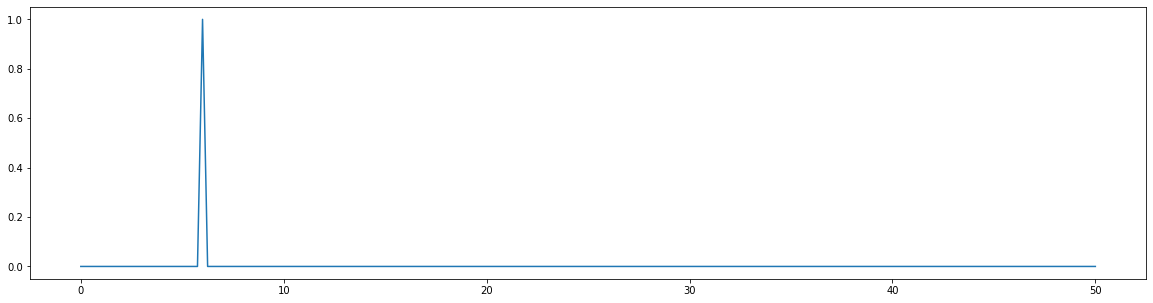

In [198]:
plt.plot(x_freq[:fftY.shape[0]],  (2 / point_count) * np.abs(fftY)[:fftY.shape[0]])

Максимум = 50 потому что это частота найквиста

In [8]:
sound = AudioSegment.from_mp3("/home/araxal/harddrive/fma_small/155/155066.mp3")

In [9]:
# Парсим pydub AudioSegment в numpy массив уровней квантизации. Массив может состоять из 1 стобца(канала) при моно звуке и из 2 столбцов(каналов) при стерео
def pydub_to_np(audio: AudioSegment) -> np.ndarray:
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels))

In [10]:
pydub_to_np(sound)

array([[4339.,   74.],
       [4494.,  -42.],
       [4636., -122.],
       ...,
       [ 878.,  524.],
       [1019.,  323.],
       [1191.,  134.]], dtype=float32)

In [11]:
# Трансформирует стерео звук в моно, вычисляя среднее между левым и правым каналом. dtype = int чтобы округлить до нижнего уровня
def stereo_to_mono(stereo: np.ndarray) -> np.ndarray:
    return np.mean(stereo, axis = 1, dtype=int)

In [12]:
stereo_to_mono(pydub_to_np(sound))

array([2206, 2226, 2257, ...,  701,  671,  662])

In [13]:
max(stereo_to_mono(pydub_to_np(sound)))

32744

In [14]:
# Нормализирует массив уровней квантизации к [-1, 1] интервалам
def normalize_mono(mono_sound: np.ndarray, sample_width: int) -> np.ndarray:
    bitrate = 1 << (8 * sample_width - 1)
    return mono_sound / bitrate

In [15]:
# Денормализирует массив уровней квантизации обратно к исходному интервалу
def denormalize_mono(mono_sound: np.ndarray, sample_width: int) -> np.ndarray:
    bitrate = 1 << (8 * sample_width - 1)
    res = mono_sound * bitrate
    return res.astype('int')

In [16]:
normalize_mono(stereo_to_mono(pydub_to_np(sound)), sound.sample_width)

array([0.06732178, 0.06793213, 0.06887817, ..., 0.02139282, 0.02047729,
       0.02020264])

In [17]:
denormalize_mono(normalize_mono(stereo_to_mono(pydub_to_np(sound)), sound.sample_width), 2)

array([2206, 2226, 2257, ...,  701,  671,  662])

In [18]:
track = normalize_mono(stereo_to_mono(pydub_to_np(sound)), sound.sample_width)

In [19]:
X = np.arange(0, len(track), 1) / sound.frame_rate

In [20]:
Y = track

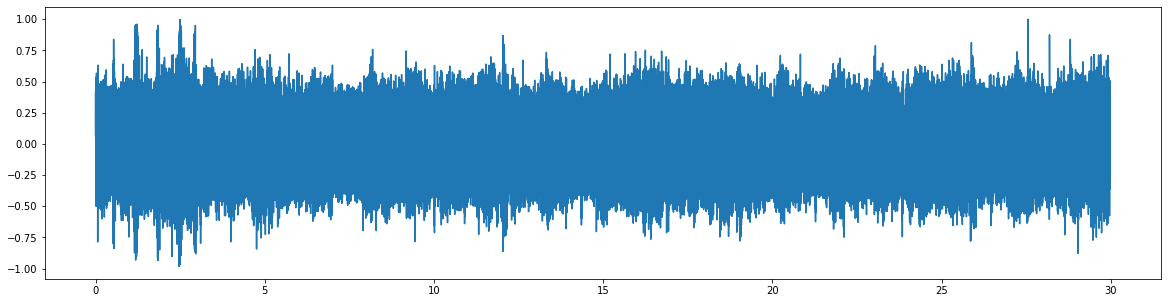

In [21]:
plt.plot(X, Y)

In [22]:
mono_track = stereo_to_mono(pydub_to_np(sound))

In [23]:
AudioSegment(array.array(sound.array_type, mono_track), channels=1, sample_width=2, frame_rate=44100)

In [24]:
denormalized_track = denormalize_mono(normalize_mono(mono_track, sound.sample_width), sound.sample_width)

In [25]:
AudioSegment(array.array(sound.array_type, denormalized_track), channels=1, sample_width=2, frame_rate=44100)

In [26]:
AudioSegment.from_mp3("/home/araxal/harddrive/mono.mp3")

In [27]:
# Фурье

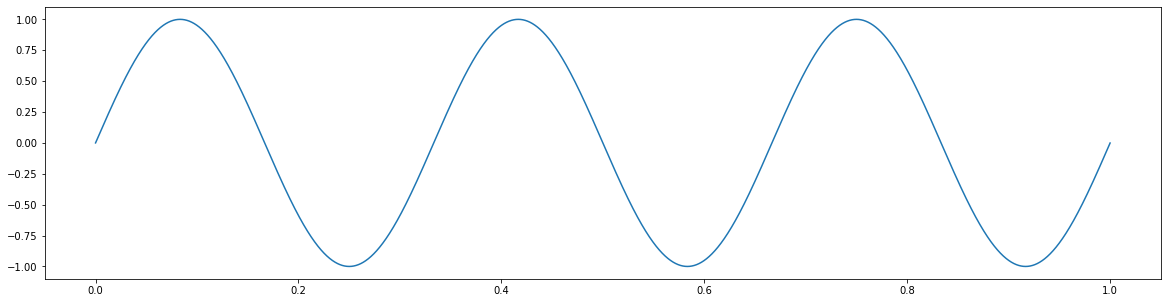

In [28]:
frequency = 3
func = lambda x: amplitude * np.sin(2 * pi * x * frequency)
X = np.arange(0, 1, 0.00005)
Y = func(X)
plt.plot(X, Y)

In [29]:
# 3 цикла в секунду

In [30]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

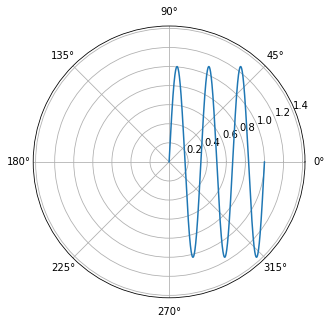

In [31]:
# Так неправильно потому что r - y а не x
newR, newTheta = list(zip(*[cart2pol(x, y) for (x, y) in zip(X, Y)]))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(newTheta, newR)

In [32]:
cart2pol(1,1)

(1.4142135623730951, 0.7853981633974483)

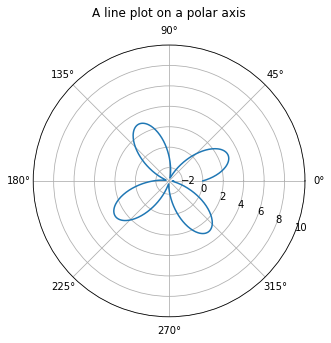

In [33]:
theta = np.arange( 0, 2 * pi, 0.01)
r = 3 * np.sin(3.8 * theta)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, r)
ax.set_rmax(10)
# ax.set_rmin(0)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

Text(0, 0.5, 'Амплитуда')

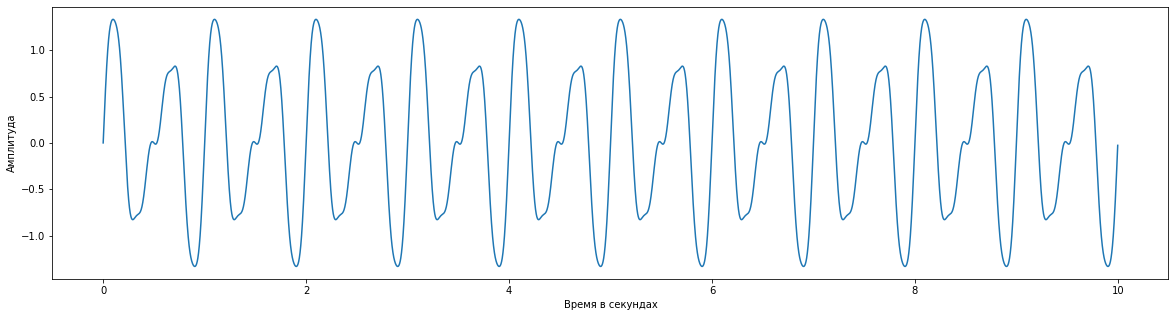

In [34]:
frequency = 1
discr = 1 / 1000
func = lambda x: amplitude * np.sin(2 * pi * x * frequency * 2) \
                 + 0.5 * amplitude * np.sin(2 * pi * x * frequency * 3)\
                 + 0.1 * amplitude * np.sin(2 * pi * x * frequency * 7)

X = np.arange(0, 10, discr)
Y = func(X)
plt.plot(X, Y)
plt.xlabel('Время в секундах')
plt.ylabel('Амплитуда')

Text(0, 0.5, 'Амплитуда хз в чем')

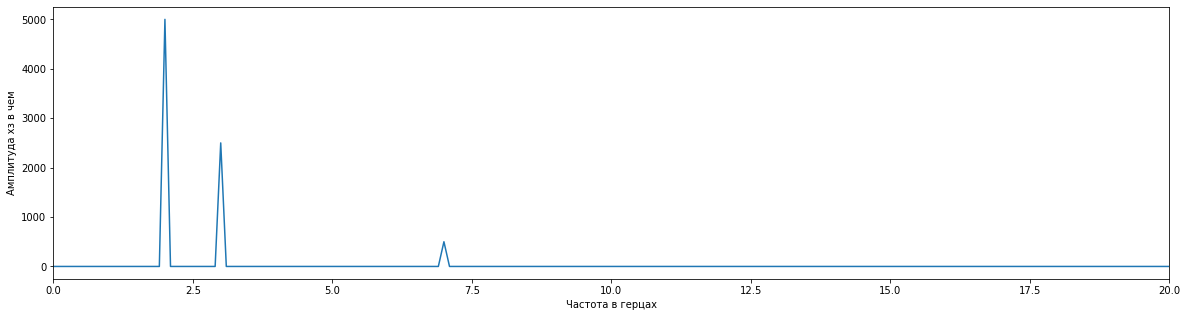

In [35]:
fftX = np.fft.rfftfreq(len(Y), d = discr)
fftY = np.fft.rfft(Y)
plt.plot(fftX, np.abs(fftY))
plt.xlim(xmin = 0,xmax=20)
plt.xlabel('Частота в герцах')
plt.ylabel('Амплитуда хз в чем')

In [36]:
irfftY = np.fft.irfft(fftY)

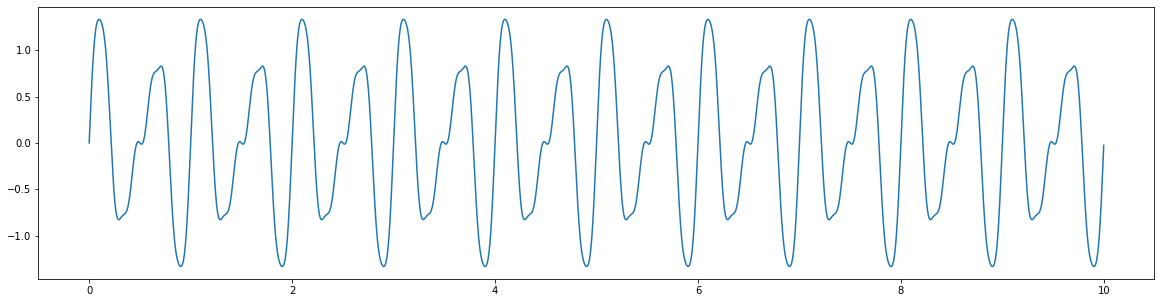

In [37]:
plt.plot(X, irfftY)

In [38]:
max(Y), max(fftY)

(1.3320212055982739, (3.2309464938571282e-12+1.4329060078634113e-12j))

Text(0, 0.5, 'Амплитуда хз в чем')

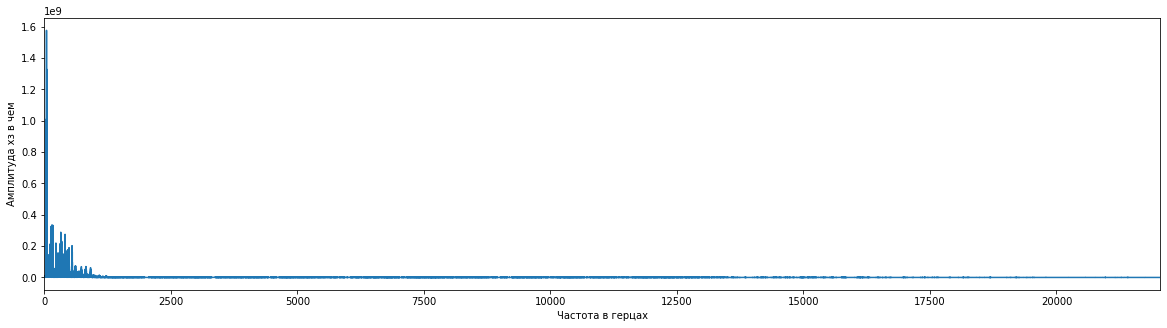

In [39]:
fftX = np.fft.rfftfreq(len(mono_track), d = 1 / sound.frame_rate)
fftY = np.fft.rfft(mono_track)
plt.plot(fftX[0 : int(len(mono_track) / 2)], np.abs(fftY)[0 : int(len(mono_track) / 2)])
plt.xlim(xmin = 0,xmax=sound.frame_rate / 2)
plt.xlabel('Частота в герцах')
plt.ylabel('Амплитуда хз в чем')

Text(0, 0.5, 'Амплитуда хз в чем')

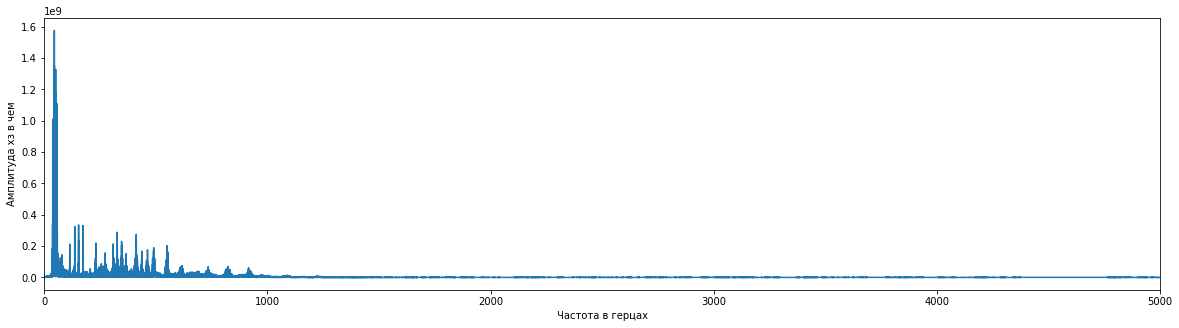

In [40]:
plt.plot(fftX, np.abs(fftY))
plt.xlim(xmin = 0,xmax=5000)
plt.xlabel('Частота в герцах')
plt.ylabel('Амплитуда хз в чем')

In [41]:
n = 0
sample_size = 4096
mono_track_first_sample = mono_track[n * sample_size : (n+1) * sample_size]
fftX = np.fft.rfftfreq(sample_size, d = 1 / sound.frame_rate)
fftY = np.fft.rfft(mono_track_first_sample)

Text(0, 0.5, 'Амплитуда хз в чем')

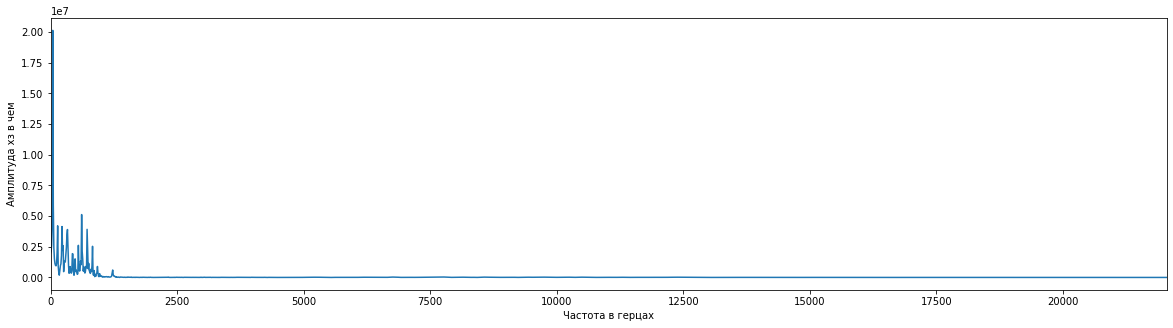

In [42]:
plt.plot(fftX, np.abs(fftY))
plt.xlim(xmin = 0, xmax=sound.frame_rate / 2)
plt.xlabel('Частота в герцах')
plt.ylabel('Амплитуда хз в чем')

Text(0, 0.5, 'Амплитуда хз в чем')

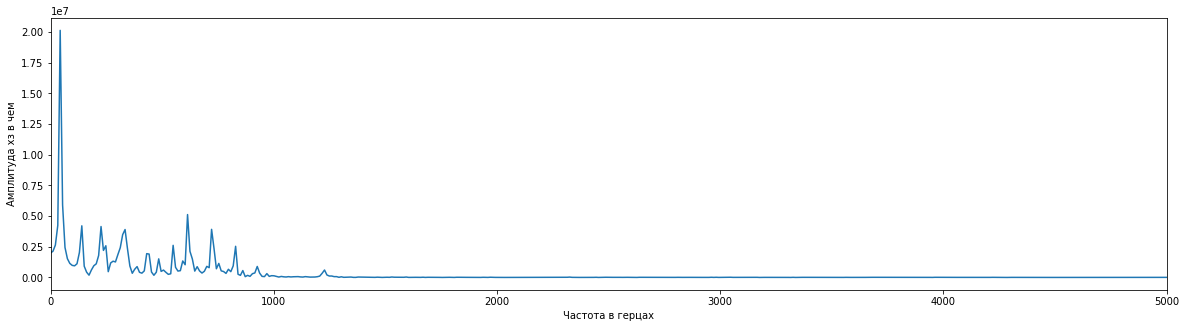

In [43]:
plt.plot(fftX, np.abs(fftY))
plt.xlim(xmin = 0,xmax=5000)
plt.xlabel('Частота в герцах')
plt.ylabel('Амплитуда хз в чем')

In [44]:
# продолжительность в секундах
len(mono_track) / 44100

29.976575963718822

In [45]:
# 1 семпл секунд (0.1 мс)
1 / 44100 * 4096

0.09287981859410431

In [46]:
# Кол-во окон (fff операций)

In [47]:
len(mono_track) / 4096

322.745849609375

In [48]:
sample_size = 4096
frame_rate = sound.frame_rate
# округляем в меньшую сторону, на конец пофиг, иначе придется заполнять нулями
X = np.arange(0, int(len(mono_track) / sample_size))

In [95]:
get_sample_fft = lambda n, trk, sample_size : np.fft.rfft(trk[n * sample_size : (n + 1) * sample_size])

In [96]:
# samples = []
# for n in X:
#     sample = mono_track[n * sample_size : (n+1) * sample_size]
#     fftY = np.fft.rfft(sample)
#     samples.append()

samples = np.array([get_sample_fft(n, mono_track, sample_size) for n in np.arange(0, int(len(mono_track) / sample_size))])
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot([np.max(np.abs(sample)) for sample in samples])
ax2.plot([np.min(np.abs(sample)) for sample in samples])

TypeError: slice indices must be integers or None or have an __index__ method

In [51]:
np.abs(samples).shape[::-1], np.fft.rfftfreq(sample_size, d = 1 / sound.frame_rate).shape

((2049, 322), (2049,))

(0.0, 5000.0)

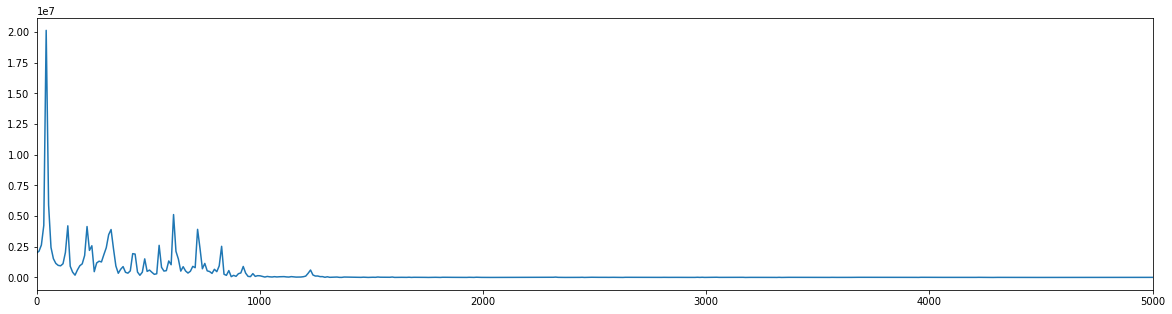

In [52]:
plt.plot(np.fft.rfftfreq(sample_size, d = 1 / sound.frame_rate), np.abs(samples)[0])
plt.xlim(xmin = 0, xmax = 5000)

In [53]:
plt.rcParams["figure.figsize"] = (20,100)

In [54]:
val = np.abs(samples).astype('int').reshape(samples.shape[::-1])
val = val / np.max(val, axis=0)

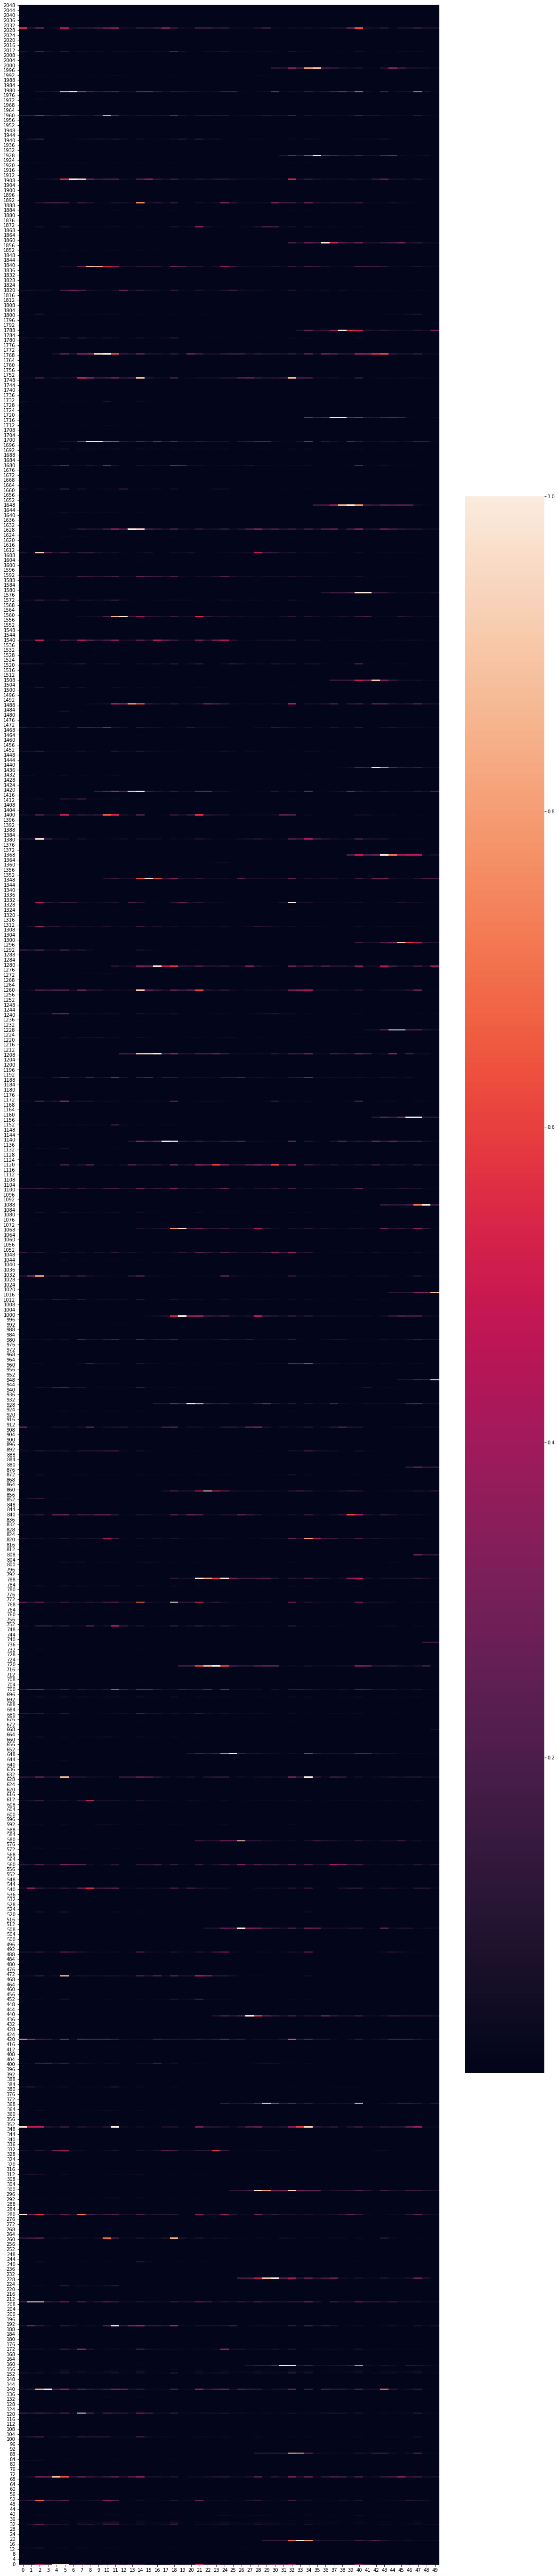

In [55]:

g = sns.heatmap(val[:, 0:50])
# g = sns.heatmap(val)
g.invert_yaxis()

In [56]:
plt.rcParams["figure.figsize"] = (20,5)

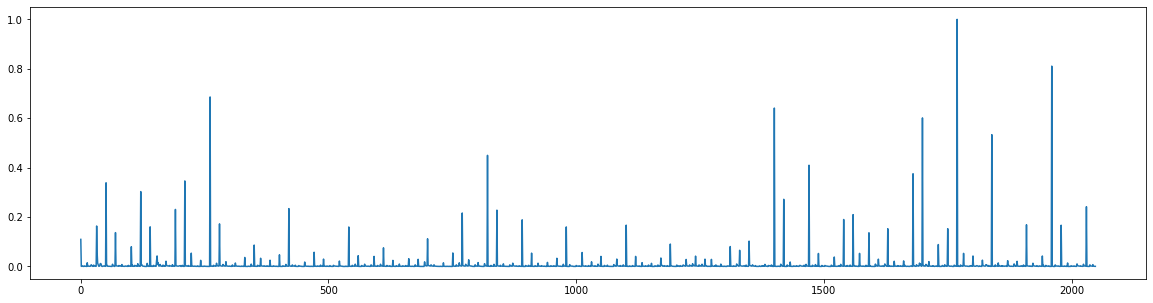

In [57]:
plt.plot(val[:, 10])

In [58]:
irfftY = np.fft.irfft(np.fft.rfft(mono_track))

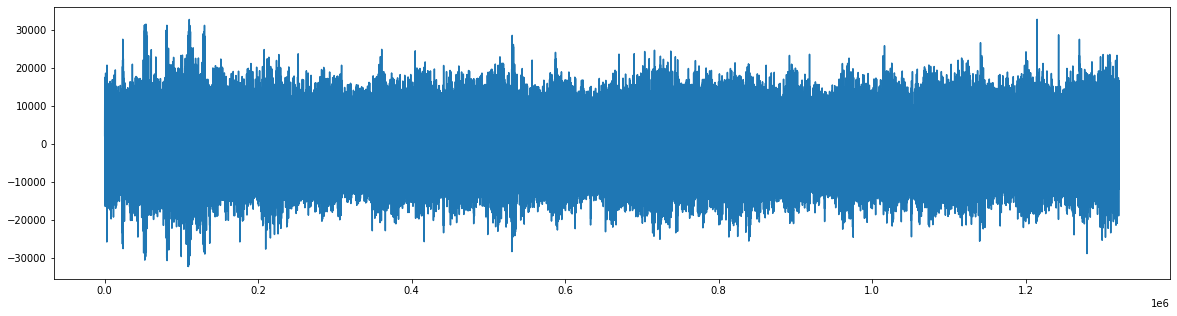

In [59]:
plt.plot(irfftY)

In [60]:
AudioSegment(array.array(sound.array_type, irfftY.astype('int')), channels=1, sample_width=2, frame_rate=44100)

In [61]:
irfftY

array([2206.01872098, 2225.98429341, 2257.01926431, ...,  700.98292906,
        671.01829296,  661.9826454 ])

In [62]:
fftY = np.concatenate(samples)

In [63]:
irfftY = np.fft.irfft(fftY)

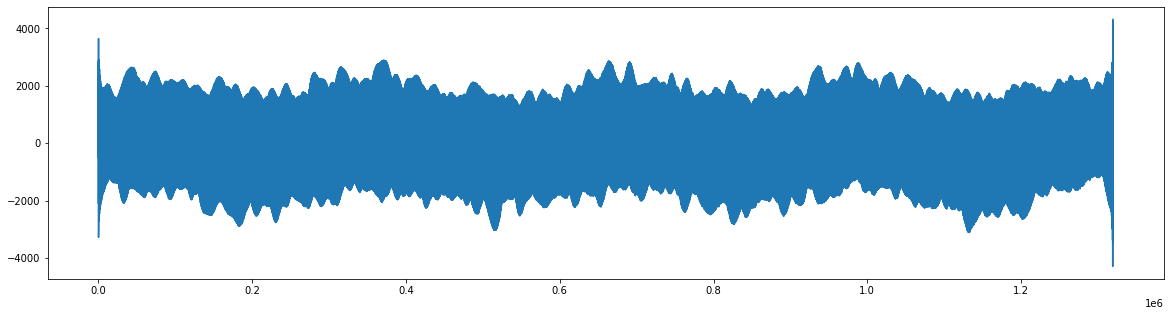

In [64]:
plt.plot(irfftY)

In [65]:
AudioSegment(array.array(sound.array_type, irfftY.astype('int')), channels=1, sample_width=2, frame_rate=44100)

In [171]:
frequency = 1
discr = 1000
func = lambda x: amplitude * np.sin(2 * pi * x * frequency)
X = np.arange(0, 10, 1 / discr)
Y = func(X)

In [172]:
fftY = np.fft.rfft(Y)
fftX = np.fft.rfftfreq(len(Y), d = 1 / discr)

In [173]:
discr

1000

(0.0, 100.0)

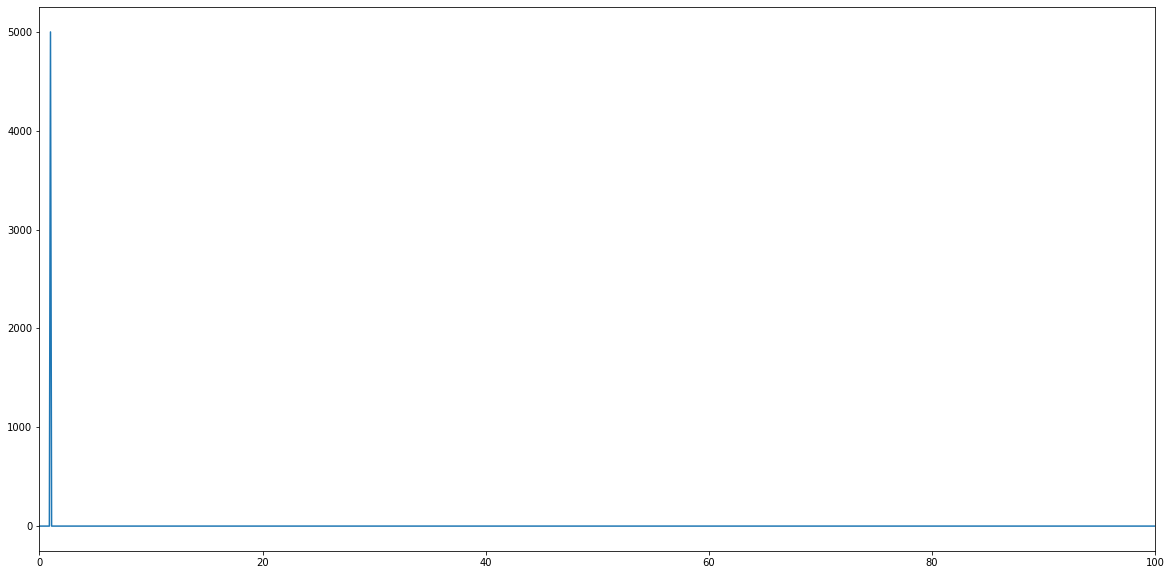

In [174]:
plt.plot(fftX, np.abs(fftY))
plt.xlim(xmin = 0, xmax = 100)

In [248]:
sample_size = 4096
frame_rate = discr
samples = np.array([get_sample_fft(n, Y, sample_size) for n in np.arange(0, int(len(Y) / sample_size))])

In [249]:
plt.rcParams["figure.figsize"] = (20,10)

(0.0, 1000.0)

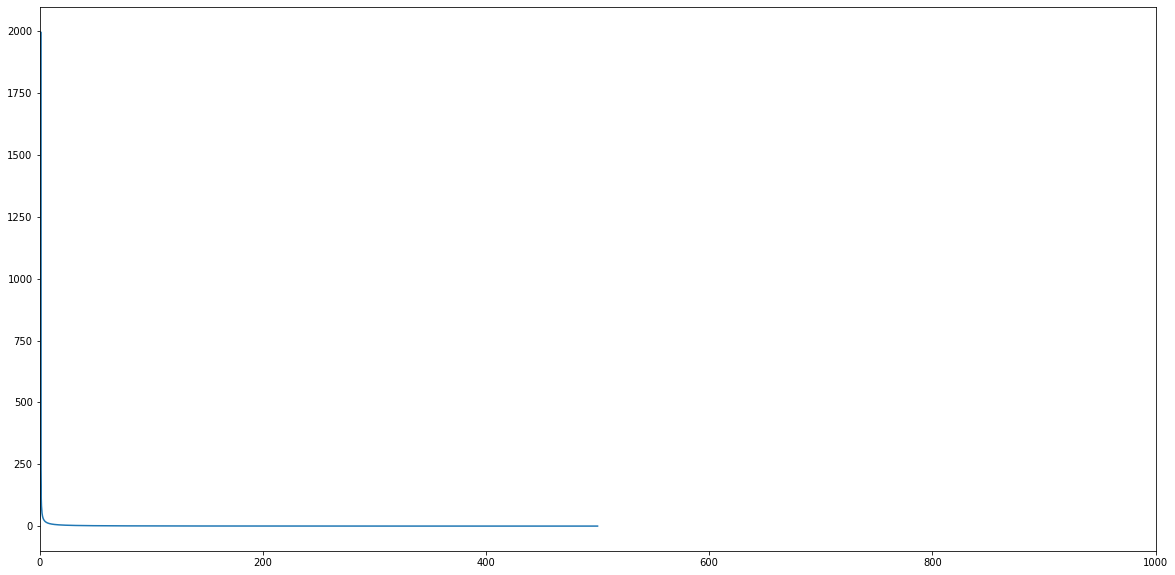

In [250]:
plt.plot(np.fft.rfftfreq(sample_size, d = 1 / frame_rate), np.abs(samples[0]))
plt.xlim(xmin = 0, xmax = 1000)

In [251]:
plt.rcParams["figure.figsize"] = (20,10)

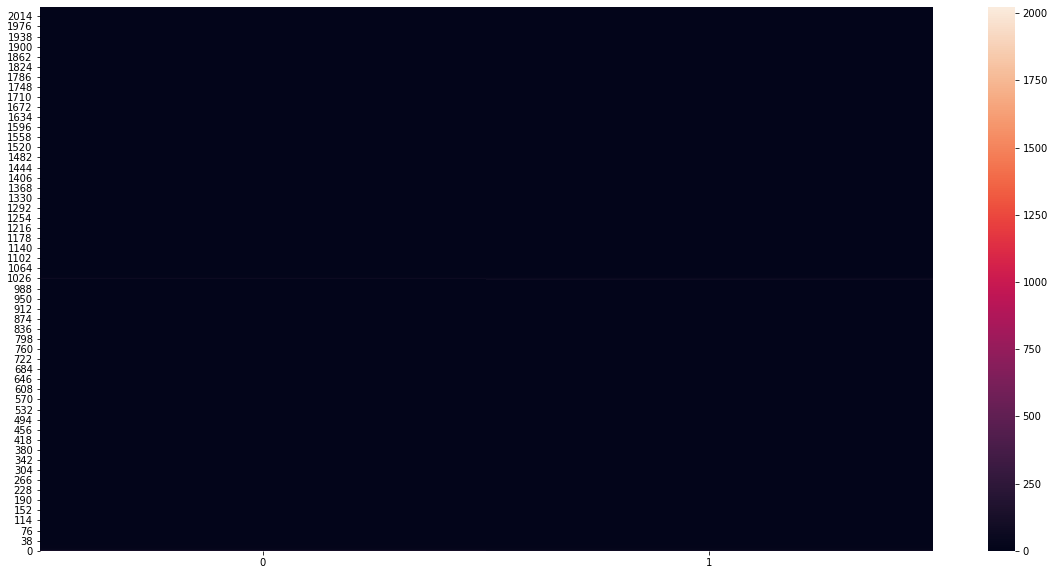

In [252]:
val = np.abs(samples).astype('int').reshape(samples.shape[::-1])

g = sns.heatmap(val)
# g = sns.heatmap(val)
g.invert_yaxis()

In [253]:
plt.rcParams["figure.figsize"] = (20,10)

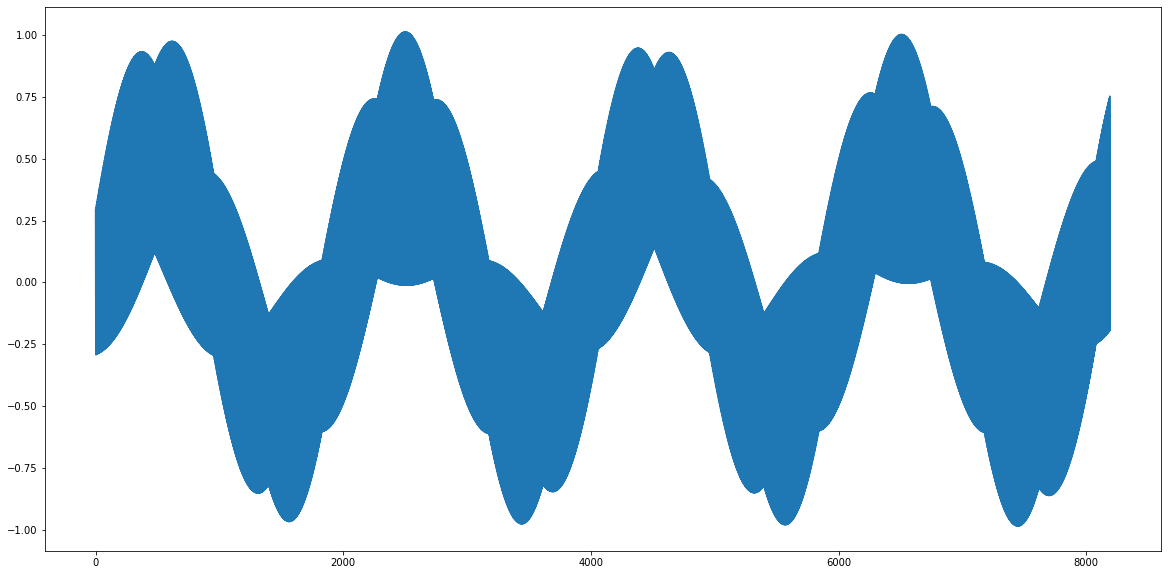

In [254]:
fftY = np.concatenate(samples)
irfftY = np.fft.irfft(fftY)
plt.plot(irfftY)

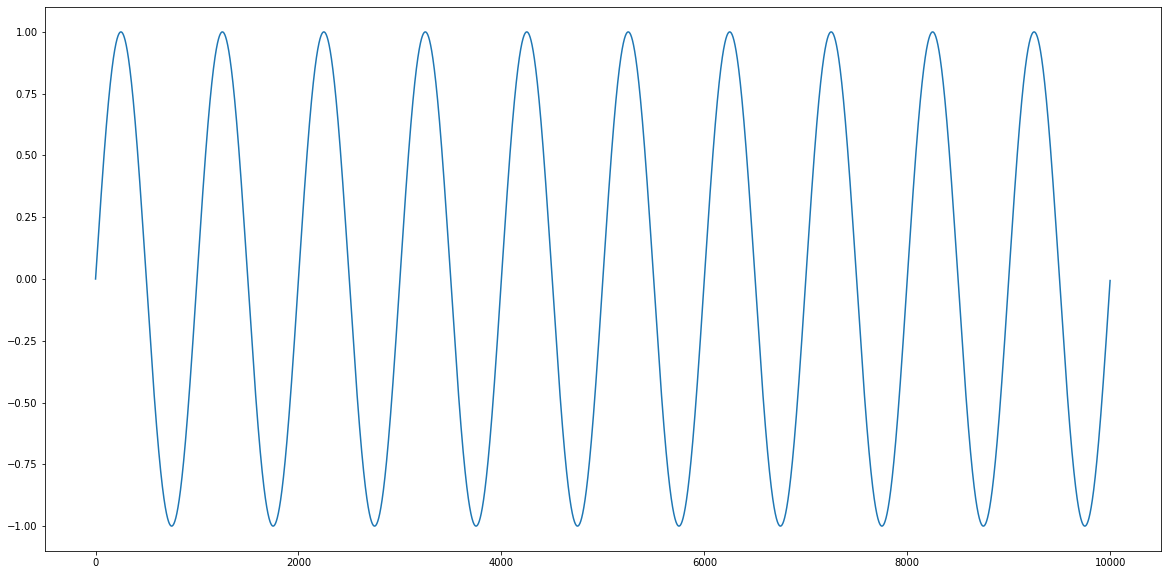

In [255]:
plt.plot(Y)